In [1]:
# import all needed libraries
import pandas as pd
import numpy as np
import numpy.random as nr
import sys
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.model_selection as ms
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import feature_selection as fs

from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV

In [2]:
# load the cleaned dataset
clean_data = pd.read_csv(r'/Users/frederikbomheuer/Desktop/1.Semester/MachineLearing/Project/CO2/data/data_cleaned2.csv')


In [3]:
clean_data.head()

,country,year,clean_fuel_access_perc,elec_access_perc,nat_res_depl_perc,forest_depl_perc,agri_land_perc,agri_forest_fish_val_perc,co2_emissions_per_capita,cooling_degree_days,...,mortality_rate_under_5,net_migration,nitrous_oxide_emissions_per_capita,population_65_above_perc,population_density,female_to_male_labor_force_ratio,renewable_energy_consumption_perc,scientific_journal_articles,precipitation_evapotranspiration,unemployment_total_perc
0,Albania,2000,38.7,99.430855,0.467306,0.122940,41.751825,24.515412,1.031568,710.17,...,27.2,-63610.0,0.384636,7.821964,112.738212,69.454576,41.36,22.34,-2.147378,19.028
1,Albania,2001,41.0,99.421989,0.286160,0.060695,41.569343,22.716164,1.056868,686.38,...,25.8,-62059.0,0.375930,8.145374,111.685146,69.303040,39.04,18.38,-1.776391,18.575
2,Albania,2002,43.8,99.404579,0.296077,0.064922,41.605839,22.025114,1.233002,566.02,...,24.4,-59876.0,0.425487,8.508105,111.350730,69.232075,35.82,24.53,0.058111,17.895
3,Albania,2003,46.5,99.385628,0.312900,0.061352,40.912409,21.978257,1.361159,931.89,...,22.9,-57308.0,0.431772,8.899816,110.934890,69.876243,33.67,22.82,-0.869403,16.989
4,Albania,2004,49.2,99.372139,0.365360,0.052754,40.948905,20.537486,1.427944,554.96,...,21.5,-54383.0,0.420342,9.308444,110.472226,70.592238,35.84,17.91,-0.052818,16.310


In [4]:
# Re-format the date column and set it as index
clean_data['year'] = pd.to_datetime(clean_data['year'], format='%Y')
clean_data.set_index('year', inplace = True)
clean_data.sort_index(inplace = True)

In [5]:
clean_data.head()

,country,clean_fuel_access_perc,elec_access_perc,nat_res_depl_perc,forest_depl_perc,agri_land_perc,agri_forest_fish_val_perc,co2_emissions_per_capita,cooling_degree_days,energy_intensity_primary_energy,...,mortality_rate_under_5,net_migration,nitrous_oxide_emissions_per_capita,population_65_above_perc,population_density,female_to_male_labor_force_ratio,renewable_energy_consumption_perc,scientific_journal_articles,precipitation_evapotranspiration,unemployment_total_perc
year,,,,,,,,,,,,,,,,,,,,,
2000-01-01,Albania,38.7,99.430855,0.467306,0.122940,41.751825,24.515412,1.031568,710.17,4.130000,...,27.2,-63610.0,0.384636,7.821964,112.738212,69.454576,41.360000,22.34,-2.147378,19.028
2000-01-01,Montenegro,66.4,99.092857,4.579793,1.346549,40.068974,11.301878,2.513999,406.40,5.517463,...,14.2,-4423.0,0.207127,10.909652,177.511786,75.152208,33.617818,0.00,-1.726908,30.330
2000-01-01,Tanzania,0.6,8.651097,0.180817,0.000000,38.383382,26.208259,0.085493,2836.09,12.300000,...,129.9,-12539.0,0.484782,2.784651,38.906868,95.187860,93.730000,150.68,-1.254995,3.152
2000-01-01,"Congo, Dem. Rep.",1.1,6.700000,7.316344,6.707605,11.292208,31.972358,0.033629,3503.07,16.450000,...,160.1,-48028.0,0.202237,2.950883,21.444748,96.803387,97.940000,15.01,-1.265538,3.356
2000-01-01,Morocco,90.2,69.812225,0.033964,0.000000,68.680260,10.728632,1.151363,2054.50,3.630000,...,52.4,-90376.0,0.243422,4.294987,63.980316,32.160002,15.260000,870.34,-1.452023,13.580


In [6]:
# Create dummy variables for each country
data_with_dummies = pd.get_dummies(clean_data, columns=['country'], prefix='', prefix_sep='')

In [7]:
data_with_dummies.head()

,clean_fuel_access_perc,elec_access_perc,nat_res_depl_perc,forest_depl_perc,agri_land_perc,agri_forest_fish_val_perc,co2_emissions_per_capita,cooling_degree_days,energy_intensity_primary_energy,fertility_rate,...,United Arab Emirates,United Kingdom,United States,Uruguay,Uzbekistan,"Venezuela, RB",Viet Nam,"Yemen, Rep.",Zambia,Zimbabwe
year,,,,,,,,,,,,,,,,,,,,,
2000-01-01,38.7,99.430855,0.467306,0.122940,41.751825,24.515412,1.031568,710.17,4.130000,2.231,...,False,False,False,False,False,False,False,False,False,False
2000-01-01,66.4,99.092857,4.579793,1.346549,40.068974,11.301878,2.513999,406.40,5.517463,2.065,...,False,False,False,False,False,False,False,False,False,False
2000-01-01,0.6,8.651097,0.180817,0.000000,38.383382,26.208259,0.085493,2836.09,12.300000,5.686,...,False,False,False,False,False,False,False,False,False,False
2000-01-01,1.1,6.700000,7.316344,6.707605,11.292208,31.972358,0.033629,3503.07,16.450000,6.718,...,False,False,False,False,False,False,False,False,False,False
2000-01-01,90.2,69.812225,0.033964,0.000000,68.680260,10.728632,1.151363,2054.50,3.630000,2.796,...,False,False,False,False,False,False,False,False,False,False


In [8]:
# Show the last 5 rows of the DataFrame
data_with_dummies.tail()

,clean_fuel_access_perc,elec_access_perc,nat_res_depl_perc,forest_depl_perc,agri_land_perc,agri_forest_fish_val_perc,co2_emissions_per_capita,cooling_degree_days,energy_intensity_primary_energy,fertility_rate,...,United Arab Emirates,United Kingdom,United States,Uruguay,Uzbekistan,"Venezuela, RB",Viet Nam,"Yemen, Rep.",Zambia,Zimbabwe
year,,,,,,,,,,,,,,,,,,,,,
2020-01-01,61.8,99.853111,0.212690,0.174089,19.178439,7.554892,4.067561,404.33,3.76,1.750,...,False,False,False,False,False,False,False,False,False,False
2020-01-01,51.4,99.502167,5.480119,0.000000,72.358944,12.965656,6.430645,367.39,6.64,2.900,...,False,False,False,False,False,False,False,False,False,False
2020-01-01,97.5,100.000000,0.004433,0.000000,68.865061,9.366692,3.267846,877.28,5.08,1.770,...,False,False,False,False,False,False,False,False,False,False
2020-01-01,34.1,89.900000,0.514789,0.513311,28.747820,22.180090,0.509366,1393.38,5.69,2.055,...,False,False,False,False,False,False,False,False,False,False
2020-01-01,30.3,52.747667,4.108902,2.315889,41.876696,8.772859,0.530484,2640.14,13.71,3.545,...,False,False,False,False,False,False,False,False,False,True


In [9]:
train_start = '2000-01-01'
train_end = '2016-01-01'

test_start = '2016-01-01'
test_end = '2020-01-01'

forecast_start = '2022-01-01'
forecast_end = '2026-01-01'

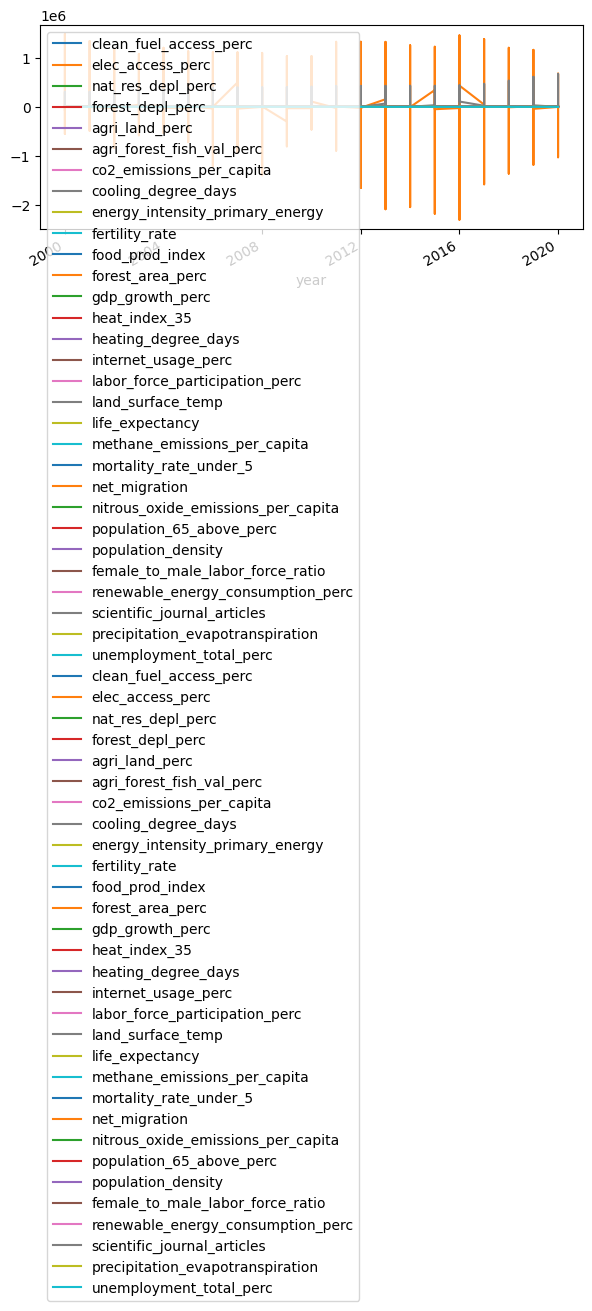

In [10]:
fig, ax = plt.subplots(figsize=(7, 3))
data_with_dummies.loc[train_start:train_end].plot(ax=ax, label = "Train")
data_with_dummies.loc[test_start:test_end].plot(ax=ax, label = "Test")
ax.legend()

In [19]:
import pmdarima as pm

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ARIMA Train Predictions: year
2000-01-01    4.662299
2000-01-01    4.662299
2000-01-01    4.662299
2000-01-01    4.662299
2000-01-01    4.662299
                ...   
2018-01-01    4.662299
2018-01-01    4.662299
2018-01-01    4.662299
2018-01-01    4.662299
2018-01-01    4.662299
Name: predicted_mean, Length: 3040, dtype: float64
ARIMA Test Predictions: year
2019-01-01   NaN
2019-01-01   NaN
2019-01-01   NaN
2019-01-01   NaN
2019-01-01   NaN
              ..
2020-01-01   NaN
2020-01-01   NaN
2020-01-01   NaN
2020-01-01   NaN
2020-01-01   NaN
Length: 320, dtype: float64


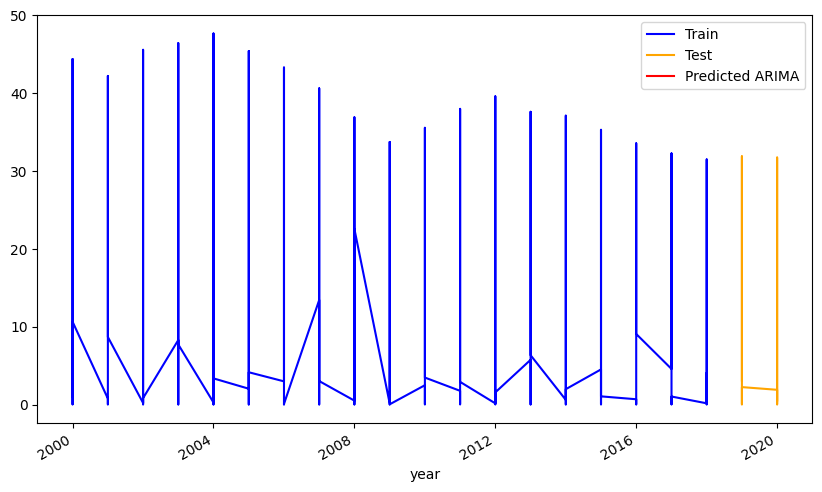

In [22]:
# Select the target variable column (e.g., 'co2_emissions_per_capita')
y_train = data_with_dummies.loc[train_start:train_end, 'co2_emissions_per_capita']
y_test = data_with_dummies.loc[test_start:test_end, 'co2_emissions_per_capita']

# Initialize and fit the AutoARIMA model
arima = pm.AutoARIMA(seasonal=False)
arima.fit(y_train)

# Predict train and test
arima_train = arima.predict_in_sample()
arima_test = arima.predict(len(y_test))

# Convert predictions to pandas Series with the same index as the train and test data
arima_train = pd.Series(arima_train, index=y_train.index)
arima_test = pd.Series(arima_test, index=y_test.index)

# Print the predicted values
print("ARIMA Train Predictions:", arima_train)
print("ARIMA Test Predictions:", arima_test)

# Plot the actual test data and the predictions
fig, ax = plt.subplots(figsize=(10, 6))
y_train.plot(ax=ax, label='Train', color='blue')
y_test.plot(ax=ax, label='Test', color='orange')
arima_test.plot(ax=ax, label='Predicted ARIMA', color='red')
ax.legend()
plt.show()

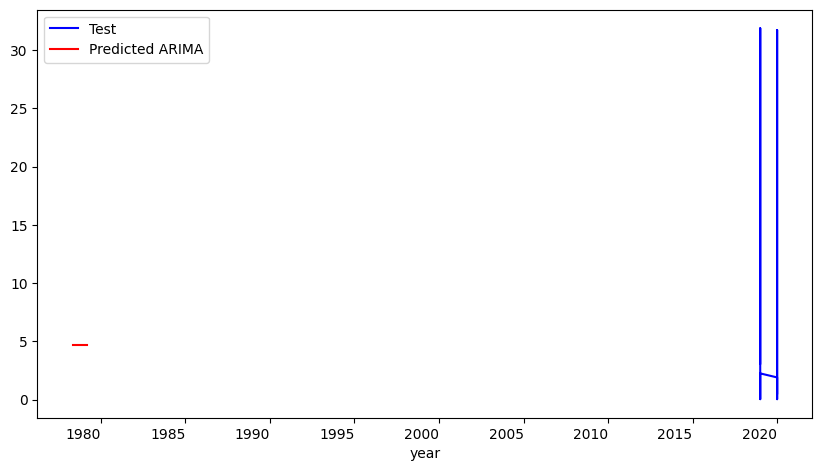

In [21]:
# Plot the actual test data and the predictions
fig, ax = plt.subplots(figsize=(10, 6))
y_test.plot(ax=ax, label='Test', color='blue')
arima_test.plot(ax=ax, label='Predicted ARIMA', color='red')
ax.legend()
plt.show()

-------

In [ ]:
from sklearn.model_selection import TimeSeriesSplit 

tss = TimeSeriesSplit(n_splits=4)

lagged_data.set_index('year', inplace=True)
lagged_data.sort_index(inplace=True)

# Create lagged variables for CO2 emissions per capita
lagged_data['co2_emissions_per_capita_lag1'] = lagged_data.groupby('country')['co2_emissions_per_capita'].shift(1)
lagged_data['co2_emissions_per_capita_lag2'] = lagged_data.groupby('country')['co2_emissions_per_capita'].shift(2)

# Drop rows with NaN values created by lag features
lagged_data.dropna(inplace=True)

X = lagged_data.drop(labels=['co2_emissions_per_capita'], axis=1)
y = lagged_data['co2_emissions_per_capita']

In [ ]:
# train test split for a time series dataset
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

Text(0.5, 1.0, 'Mean CO2 Emissions per Capita by Year')

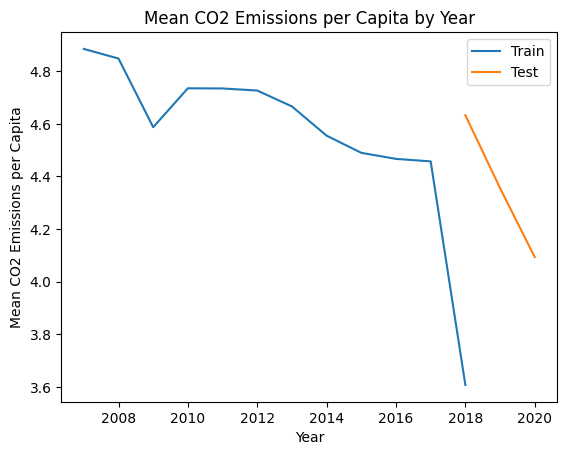

In [ ]:
# Plot the mean CO2 emissions per capita by year for train and test sets
y_train.groupby('year').mean().plot(label='Train', legend=True)
y_test.groupby('year').mean().plot(label='Test', legend=True)

plt.xlabel('Year')
plt.ylabel('Mean CO2 Emissions per Capita')
plt.title('Mean CO2 Emissions per Capita by Year')

In [ ]:
from sklearn.metrics import mean_squared_error

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

ValueError: could not convert string to float: 'Hungary'

In [ ]:
# Forecasting the next 5 years
# Assuming you have the features for the next 5 years in X_future
# You need to create X_future with the same number of features as X_train

# Example: Creating a dummy X_future with the same number of features
# Replace this with your actual future data
num_features = X_train.shape[1]
X_future = np.random.rand(5, num_features)  # 5 future data points with the same number of features

# Ensure X_future is in the correct shape
X_future = X_future.reshape(-1, num_features)

y_future_pred = model.predict(X_future)
print(f'Forecasted CO2 Emissions per Capita for the next 5 years: {y_future_pred}')

AttributeError: 'RandomForestRegressor' object has no attribute 'estimators_'